In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

from scipy.stats import multivariate_normal

from homework2 import GaussianMixture

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

K = 4

In [3]:
g = GaussianMixture(data_train.values, 4, 'general', display='none')
g.fit()

In [4]:
means, covs = g.mus.T, g.sigmas

In [5]:
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """
    Create a grid in the form of a list of points stored in a 2D array
    """

    if data is not None:
        xmax, xmin,  = np.max(data[:, 0]), np.min(data[:, 0])
        ymax, ymin = np.max(data[:, 1]), np.min(data[:, 1])
        
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1./step), 
                       np.arange(ymin, ymax, (ymax-ymin)*1./step))
    
    grid = np.c_[x.ravel(), y.ravel()]

    return grid, x, y

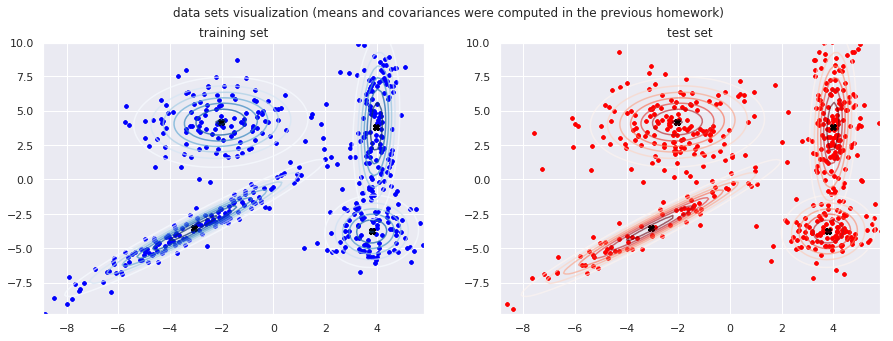

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('data sets visualization (means and covariances were computed in the previous homework)')

grid, x_grid, y_grid = make_grid(data=data_train.values, step=100)

ax1.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
ax1.set_title('training set')

for j in range(K):
    ax1.scatter(x=data_train.values[:, 0], y=data_train.values[:, 1], c='blue', marker='.')
    ax1.scatter(x=means[:, 0], y=means[:, 1], c='black', marker='X')
    ax1.contour(x_grid, y_grid, multivariate_normal.pdf(grid, mean=means[j],
                                                        cov=covs[j]).reshape(x_grid.shape),
                levels=None, alpha=0.7, linestyles='solid', cmap='Blues')
    
ax2.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
ax2.set_title('test set')

for j in range(K):
    ax2.scatter(x=data_test.values[:, 0], y=data_test.values[:, 1], c='red', marker='.')
    ax2.scatter(x=means[:, 0], y=means[:, 1], c='black', marker='X')
    ax2.contour(x_grid, y_grid, multivariate_normal.pdf(grid, mean=means[j],
                                                        cov=covs[j]).reshape(x_grid.shape),
                levels = None, alpha=0.6, linestyles='solid', cmap='Reds');

# Hidden Markov model

In [7]:
def log_sum_exp(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

def gaussian_log_pdf(x, mu, sigma):
    n = mu.size
    return - 0.5 * ((x - mu).dot(np.linalg.inv(sigma).dot(x - mu)) + n * np.log(2 * np.pi) + np.log(np.linalg.det(sigma)))

In [8]:
class GaussianHMM:
    
    def __init__(self, a, pi, mu, sigma, min_float=1e-50):
        assert(a.shape[0] == a.shape[1] == pi.shape[0] == mu.shape[0] == sigma.shape[0])
        self.num_states = a.shape[0]
        
        self.mu = mu
        self.sigma = sigma
        
        self.min_float = min_float
        self.log_a = np.log(a + min_float)
        self.log_pi = np.log(pi + min_float)
        
    # emission probabilities p(u_t|q_t=i)
    def log_f(self, u, i):
        return gaussian_log_pdf(u, self.mu[i], self.sigma[i])
    
    def log_likelihood(self, u):
        log_alpha, _, _, _ = self.forward_backward(u)
        return log_sum_exp(log_alpha[-1])
        
    def forward_backward(self, u):
        num_obs = u.shape[0]
        log_alpha = np.zeros((num_obs, self.num_states))
        log_beta = np.zeros((num_obs, self.num_states))
        
        # alpha recursion
        for t in range(num_obs):
            for i in range(self.num_states):
                if t == 0:
                    log_alpha[t, i] = self.log_pi[i] + self.log_f(u[0], i)
                else:
                    log_alpha[t, i] = log_sum_exp(log_alpha[t - 1, :] + self.log_a[:, i]) + self.log_f(u[t], i)
                
        # beta recursion
        for t in reversed(range(num_obs)):
            for i in range(self.num_states):
                if t == num_obs - 1:
                    log_beta[t, i] = 0.0
                else:
                    # array of p(u_t+1|q_t+1=j) for all j
                    p_emissions = np.array([self.log_f(u[t + 1], j) for j in range(self.num_states)])
                    
                    log_beta[t, i] = log_sum_exp(log_beta[t + 1, :] + self.log_a[i, :] + p_emissions)
                    
        # gamma and xi computation
        log_gamma = log_alpha + log_beta
        log_xi = np.zeros((num_obs - 1, self.num_states, self.num_states))
        
        for t in range(num_obs - 1):
            for i in range(self.num_states):
                for j in range(self.num_states):
                    log_xi[t, i, j] = log_alpha[t, i] + self.log_a[i, j] + log_beta[t + 1, j] + self.log_f(u[t + 1], j)
            
            log_gamma[t] -= log_sum_exp(log_alpha[t] + log_beta[t])
            log_xi[t] -= log_sum_exp(np.array([log_sum_exp(log_xi[t, i]) for i in range(self.num_states)]))
        
        return log_alpha, log_beta, log_gamma, log_xi
    
    def learn_parameters(self, u, tol, max_iter):
        num_obs = u.shape[0]
        
        former_log_likelihood = - np.inf
        for _ in range(max_iter):
            
            # E step
            
            log_alpha, log_beta, log_gamma, log_xi = self.forward_backward(u)
            gamma = np.exp(log_gamma)
            xi = np.exp(log_xi)
            
            log_likelihood = log_sum_exp(log_alpha[-1])
            
            # convergence check
            assert(former_log_likelihood <= log_likelihood)
            if abs(log_likelihood - former_log_likelihood) < tol:
                break
                
            former_log_likelihood = log_likelihood
            
            # M step
            
#            # initial probability update
#            self.log_pi = log_alpha[0] + log_beta[0]
#            self.log_pi -= log_sum_exp(self.log_pi)
            
            # transition probabilities update
#            for i in range(self.num_states):
#                for j in range(self.num_states):
#                    self.log_a[i, j] = log_sum_exp(log_xi[:, i, j]) - log_sum_exp(log_gamma[:-1, i])

            # means update
            for i in range(self.num_states):
                self.mu[i] = np.sum(gamma[:, i, np.newaxis] * u, axis=0) / np.sum(gamma[:, i])
                
            # covariance matrices update
            for i in range(self.num_states):
                temp = u - self.mu[i]
                cov_array = (temp.T.dot(np.diag(gamma[:, i]))).dot(temp)
                cov_array = cov_array / np.diag(gamma[:, i]).sum()
                
    def decode(self, u):
        num_obs = u.shape[0]
        log_v = np.zeros((num_obs, self.num_states))
        s = np.zeros(num_obs)
        
        for i in range(self.num_states):
            log_v[0, i] = self.log_pi[i] + self.log_f(u[0], i)
            
        for t in range(1, num_obs):
            for i in range(self.num_states):
                best_j = np.argmax(log_v[t - 1] + self.log_a[:, i])
                log_v[t, i] = log_v[t - 1, best_j] + self.log_a[best_j, i] + self.log_f(u[t], i)
                s[t - 1] = best_j
                
        s[num_obs - 1] = np.argmax(log_v[t - 1])
        
        return s

In [9]:
#a = np.random.rand(K, K)
a = np.ones((K, K))
for i in range(K):
    a[i] *= 1 / np.sum(a[i])
# pi = np.random.rand(K)
pi = np.ones(K)
pi *= 1 / np.sum(pi)
mu = np.copy(means)
sigma = np.copy(covs)

In [10]:
gaussian_hmm = GaussianHMM(a, pi, mu, sigma)

In [11]:
gaussian_hmm.learn_parameters(data_train.values, 1e-5, 100)

In [12]:
training_hidden_states = gaussian_hmm.decode(data_train.values).astype('int')
test_hidden_states = gaussian_hmm.decode(data_test.values).astype('int')

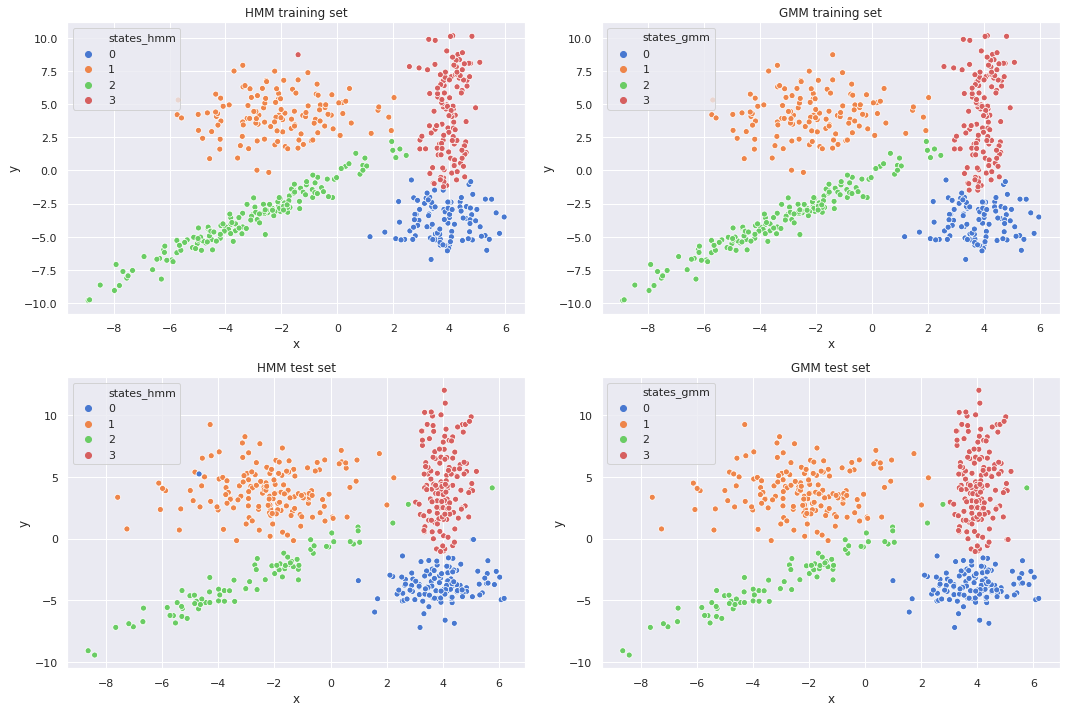

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

ax1.set_title('HMM training set')
ax2.set_title('GMM training set')

data_train_copy = data_train.copy()

data_train_copy['states_hmm'] = pd.Series(training_hidden_states)
data_train_copy['states_gmm'] = pd.Series(g.predict(data_train.values))

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax1)

sns.scatterplot(x="x", y="y", data=data_train_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax2)

ax3.set_title('HMM test set')
ax4.set_title('GMM test set')

data_test_copy = data_test.copy()

data_test_copy['states_hmm'] = pd.Series(test_hidden_states)
data_test_copy['states_gmm'] = pd.Series(g.predict(data_test.values))

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_hmm', 
                palette=sns.color_palette("muted", K), ax=ax3)

sns.scatterplot(x="x", y="y", data=data_test_copy, hue='states_gmm', 
                palette=sns.color_palette("muted", K), ax=ax4)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

fig.tight_layout();

In [14]:
print(gaussian_hmm.log_likelihood(data_train.values))
print(gaussian_hmm.log_likelihood(data_test.values))

-2334.6290537545397
-2396.5238985181827


In [15]:
g.predict(data_train.values)
g.jfunc()

-2327.7330398306485

In [16]:
g.predict(data_test.values)
g.jfunc()

-2409.216237105671

In [18]:
np.exp(gaussian_hmm.log_a)

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])